# Pranith & Raja : Assignment -3 #

In [99]:
#from mnist1d.models import MLPBase, Single_Hidden_Layer
#from mnist1d.train import get_model_args, train_model
import random

import mnist1d.models as util_models
import mnist1d.train as utils_train

from importlib import reload 

util_models = reload(util_models)
utils_train = reload(utils_train)


In [100]:
from scipy.ndimage.measurements import mean
import torch
import torch.nn as nn
import torch.nn.functional as F


class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cpu


In [101]:
import numpy as np
data_X = np.load('C:\Users\pranay\Downloads\mnist1d\train_X.npy)
data_Y = np.load('/C:\Users\pranay\Downloads\mnist1d\train_Y.npy')

In [102]:
print(data_X.shape)
print(data_Y.shape)

(500, 40)
(500,)


In [103]:
class Single_Hidden_Layer(nn.Module):

  def __init__(self, input_size, output_size, hidden_size=1000):
    super(Single_Hidden_Layer, self).__init__()
    self.linear1 = nn.Linear(input_size,hidden_size,bias=False) # this iniatialized weights to "He" initialization

    nn.init.normal_(self.linear1.weight,mean=0,std=1) # the

#    print(self.linear1.weight[:1])
    self.linear2 = nn.Linear(hidden_size, output_size)

    nn.init.uniform_(self.linear2.weight,-1,1) #  sdfdfdgfgf

#    print(self.linear2.weight)

#    print("Initialized MLPBase model with {} parameters".format(self.count_params()))


  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

  def forward(self, x):
    h = self.linear1(x).relu()

    return self.linear2(h)

## Normalizing inputs (Theorem assumption)

In [104]:
x_norm_row = np.linalg.norm(data_X, axis=1)
print(x_norm_row.shape)

x_normalized = data_X/x_norm_row.reshape(-1,1)

print(np.linalg.norm(x_normalized,axis=1)[:5])

(500,)
[1. 1. 1. 1. 1.]


## $$ \text{H}^∞ \text{ Computation} $$ ##

$\text{H}_{i,j}^∞ = x_i^Tx_j (\frac{\pi - angle(x_i,x_j)}{2\pi}) $

In [105]:
# Using Numpy broadcasting
import math

intermediate = np.dot(x_normalized,x_normalized.T)
intermediate = np.clip(intermediate, -1, 1)

#print(np.arccos(intermediate)[0:5,0:5])

# this is to check if the diagonal elements has an angle zero
#print(intermediate[0:5,0:5])

H_infinity = intermediate*(1/2 - (np.arccos(intermediate)/(2*math.pi) )    ) 
#print(H_infinity)

In [106]:
# Eigen value computation
H_Infi_Lambda = np.linalg.eigvals(H_infinity)
print(min(H_Infi_Lambda))

0.04927203661873193


In [82]:
# Checks before training
args = utils_train.get_model_args()
args.input_size = data_X.shape[1]
args.output_size = 10 
model = Single_Hidden_Layer(args.input_size, args.output_size)
print("Hidden layer weight size {}".format(model.linear1.weight.shape))
print("Output layer weight size {}".format(model.linear2.weight.shape))

Hidden layer weight size torch.Size([1000, 40])
Output layer weight size torch.Size([10, 1000])


### $$H(0) \text{computation} $$ ###

$\text{H}_{ij}(0) = \frac{1}{m}x_i^Tx_j \sum_{r=1}^{m} \text{I}{ x_i^Tw_r(0) \ge 0, x_j^Tw_r(0) \ge 0}$

1. To compute this $H_{ij}(0)$ we need the data points $x_i$ and $x_j$ and the initial random weights $w_r$ in the first layer of neural network 

2. Defining `first_part` as $x_i^Tx_j$. this quantity is computed for all $i$ and $j$ using the dot product of data matrix

$\space$

3. Defining `second_part` as $\sum_{r=1}^{m} \text{I}{ x_i^Tw_r(0) \ge 0, x_j^Tw_r(0) \ge 0}$

$\space$



$\text{H}_{ij}(0) = \frac{1}{m}x_i^Tx_j \sum_{r=1}^{m} \text{I}{ x_i^Tw_r(0) \ge 0, x_j^Tw_r(0) \ge 0}$

1. To compute this $H_{ij}(0)$ we need the data points $x_i$ and $x_j$ and the initial random weights $w_r$ in the first layer of neural network 

2. Defining `first_part` as $x_i^Tx_j$. this quantity is computed for all $i$ and $j$ using the dot product of data matrix

$\space$

3. Defining `second_part` as $\sum_{r=1}^{m} \text{I} ({ x_i^Tw_r(0) \ge 0, x_j^Tw_r(0) \ge 0})$

$\space$


\begin{equation}
\text{data}_X=
\begin{bmatrix}
    --- & x_1^T & --- \\
    --- & x_2^T & --- \\
     . \\
     . \\
--- & x_{500}^T & --- 
\end{bmatrix}
\end{equation}

and 
\begin{equation} 
w_r(0)=
\begin{bmatrix}
    --- & w_1^T & --- \\
    --- & w_2^T & --- \\
     . \\
     . \\
--- & w_{1000}^T & --- 
\end{bmatrix} 
\end{equation}


the term $x_i^Tw_r(0) \ge 0 $is computed is computed by `np.dot(data_X,weights.T) >=0)` and lets call this $A$. this matrix $A$ is of shape `500 \times 1000`

and similarly 
the term $x_j^Tw_r(0) \ge 0 $is computed is computed by the same operation `np.dot(data_X,weights.T) >=0)` and lets call this $B$. this matrix $B$ is of shape `500 \times 1000`


To computed the term $\sum_{r=1}^{m} \text{I} ({ x_i^Tw_r(0) \ge 0, x_j^Tw_r(0) \ge 0})$ . we need to run a loop across the dimension r and this is efficiently copmuted by multiplying $A$ and $B^T$


second_part = `np.dot(1* A, (1*B).T) /1000.0`

multiplication of `1` is to convert `True` and `False` to `1` and `0` respectively. and in the multipication is non-zero if both the entries are `1.` (Indication function with two clauses are satisifed)

$H(0)$ matrix is simply element wise product of `first_part` and `second_part`









In [107]:
# Checks before training
args = utils_train.get_model_args()
args.input_size = data_X.shape[1]
args.output_size = 10 
model = Single_Hidden_Layer(args.input_size, args.output_size)
print("Hidden layer weight size {}".format(model.linear1.weight.shape))
print("Output layer weight size {}".format(model.linear2.weight.shape))

Hidden layer weight size torch.Size([1000, 40])
Output layer weight size torch.Size([10, 1000])


In [108]:
#model = Single_Hidden_Layer(40,10,1000)
weights = model.linear1.weight.detach().numpy()

print(weights.shape)

#print(x_normalized.shape)

(1000, 40)


In [109]:
# Using Numpy multiplication operation to remove the for loops

#x_iwr >=0
second_part = np.dot(1* (np.dot(data_X,weights.T) >=0), (1*(np.dot(data_X,weights.T) >=0)).T) /1000.0
first_part = np.dot(x_normalized,x_normalized.T)
H_0 = first_part * second_part

In [110]:
# Eigen value computation
H_0_Lambda = np.linalg.eigvals(H_0)
print(min(H_0_Lambda))

0.04287535716300872


## Training ##

In [111]:
# Note: if you run on a GPU, the walltimes will be _much_ lower

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

args.total_steps = 10000
args.device = DEVICE
args.batch_size = 500 
args.learning_rate = 1e-10
set_seed(args.seed)

In [87]:
# Checks before training
#model = Single_Hidden_Layer(args.input_size, args.output_size)
print("Batch Size {}".format(args.batch_size))
print("Hidden layer size {}".format(model.linear1.weight.shape))
print("Output layer size {}".format(model.linear2.weight.shape))

Batch Size 500
Hidden layer size torch.Size([1000, 40])
Output layer size torch.Size([10, 1000])


In [88]:
#model = Single_Hidden_Layer(args.input_size, args.output_size)
#x = torch.normal(0,5,(10,40))
#print(type(x))
#print(model(x))

In [89]:
model = Single_Hidden_Layer(args.input_size, args.output_size)
results_mlp = utils_train.train_model(data_X,data_Y,data_X,data_Y, model, args)

Training completed for 0 steps
Training completed for 100 steps
Training completed for 200 steps
Training completed for 300 steps
Training completed for 400 steps
Training completed for 500 steps
Training completed for 600 steps
Training completed for 700 steps
Training completed for 800 steps
Training completed for 900 steps
step 1000, dt 4.23s, train_loss 3.574e+01, test_loss 3.570e+01, train_acc 10.6, test_acc 10.6
Training completed for 1000 steps
Training completed for 1100 steps
Training completed for 1200 steps
Training completed for 1300 steps
Training completed for 1400 steps
Training completed for 1500 steps
Training completed for 1600 steps
Training completed for 1700 steps
Training completed for 1800 steps
Training completed for 1900 steps
step 2000, dt 3.60s, train_loss 1.376e+01, test_loss 1.375e+01, train_acc 12.0, test_acc 12.0
Training completed for 2000 steps
Training completed for 2100 steps
Training completed for 2200 steps
Training completed for 2300 steps
Training

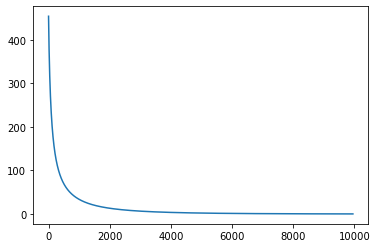

In [90]:
import matplotlib.pyplot as plt
plt.plot(results_mlp['train_losses'][50:])

1. As theoretically the error at any itreation $t$ has an expotential behaviour $(e^{-\lambda_0t})
)$

In [92]:
model = Single_Hidden_Layer(args.input_size, args.output_size)
results_mlp = utils_train.train_model2(data_X,data_Y,data_X,data_Y, model, args)

Training completed for 0 steps
Training completed for 100 steps
Training completed for 200 steps
Training completed for 300 steps
Training completed for 400 steps
Training completed for 500 steps
Training completed for 600 steps
Training completed for 700 steps
Training completed for 800 steps
Training completed for 900 steps
step 1000, dt 1.19s, train_loss 1.253e+03, test_loss 1.470e+03, train_acc 11.8, test_acc 11.8
Training completed for 1000 steps
Training completed for 1100 steps
Training completed for 1200 steps
Training completed for 1300 steps
Training completed for 1400 steps
Training completed for 1500 steps
Training completed for 1600 steps
Training completed for 1700 steps
Training completed for 1800 steps
Training completed for 1900 steps
step 2000, dt 1.72s, train_loss 1.921e+02, test_loss 5.511e+02, train_acc 16.4, test_acc 16.4
Training completed for 2000 steps
Training completed for 2100 steps
Training completed for 2200 steps
Training completed for 2300 steps
Training

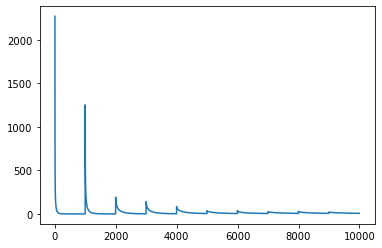

In [94]:
import matplotlib.pyplot as plt
plt.plot(results_mlp['train_losses'][5:])

1. Using stage-wise traing, the error goes to zero slowly compared to full labels training. 
2. Error increases after every 1000 iterations. this was expected since we are adding extra lebels for every 1000 iterations

In [95]:
args.total_steps = 20000
model = Single_Hidden_Layer(args.input_size, args.output_size)
results_mlp = utils_train.train_model2(data_X,data_Y,data_X,data_Y, model, args)

Training completed for 0 steps
Training completed for 100 steps
Training completed for 200 steps
Training completed for 300 steps
Training completed for 400 steps
Training completed for 500 steps
Training completed for 600 steps
Training completed for 700 steps
Training completed for 800 steps
Training completed for 900 steps
step 1000, dt 1.34s, train_loss 9.497e+02, test_loss 1.360e+03, train_acc 12.4, test_acc 12.4
Training completed for 1000 steps
Training completed for 1100 steps
Training completed for 1200 steps
Training completed for 1300 steps
Training completed for 1400 steps
Training completed for 1500 steps
Training completed for 1600 steps
Training completed for 1700 steps
Training completed for 1800 steps
Training completed for 1900 steps
step 2000, dt 1.90s, train_loss 1.963e+02, test_loss 6.084e+02, train_acc 16.2, test_acc 16.2
Training completed for 2000 steps
Training completed for 2100 steps
Training completed for 2200 steps
Training completed for 2300 steps
Training

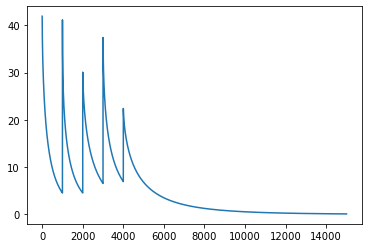

In [97]:
import matplotlib.pyplot as plt
plt.plot(results_mlp['train_losses'][5000:])

1. This plots shows after 9000 iterations (5000+4000) the erros loss goes to zero as exponential decaying $(e^{-\lambda_0t})$